<h3>Pyrochlore Metallic Spin Ice Pr2Ir2O7</h3>

The Pr ions have a doubly occupied f-orbital which in any event may be modeled as a pseudospin one-half. The Ir electrons half-fill a j=one-half orbital. Each experiences a strong easy-axis along the local-111 direction due to crystal field.

The Pr pseudospin will thus be simulated by kinetic Monte Carlo as classical Ising variables. Their interaction, princibly due to RKKY interaction mediated by the Ir electrons, is long-ranged.

We will convolve the minimal Ir band theory over the Pr Ising spins to investigate the phase inhomogeneity found in STM experiments.

The band theory will have two mean-fields: the semiclassical Ir spin structure and the Pr moments given as input.

In [ ]:
from simulate import *
from paths import *
from constants import *
from time import time as now
from copy import deepcopy
from numba import jit
import cupy as cp
import scipy.io
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from mpl_toolkits import mplot3d
%pylab
%matplotlib inline
style.use('default');mpl.rcParams['figure.max_open_warning'] = False;mpl.rcParams['figure.dpi'] = 100;mpl.rcParams['xtick.direction'] = 'in';mpl.rcParams['ytick.direction'] = 'in'

In [10]:
Npx = 32; Npy = 32; Npz = 2; Np = Nmu*Npx*Npy*Npz; state_ini = False # helper variable
Nix = 1; Niy = 1; Niz = 1; Ni = Nmu*Nix*Niy*Niz

In [15]:
radius_of_summation = 2
lattice    = zeros((Nix,Niy,Niz,3), dtype=float)
realspace  = zeros((2,Nix,Niy,Niz,Nmu,3), dtype=float)


a = 1.0                                     # Taking unit lattice spacing # 0.354*10**-9 #[m] = 0.354 nm
ann = sqrt(2*0.25**2) * a

# FCC Bravais Lattice Vectors
l0 = array([0.0, 0.0, 0.0]);     l1 = array([0, 0.5*a, 0.5*a]);
l2 = array([0.5*a, 0.0, 0.5*a]); l3 = array([0.5*a, 0.5*a, 0.0]);
l = array([l0, l1, l2, l3])

# b-site Basis Vectors
d0 = array([0.0, 0.0, 0.0]);      d1 = array([0.0, 0.25*a, 0.25*a]);
d2 = array([0.25*a, 0.0, 0.25*a]);    d3 = array([0.25*a, 0.25*a, 0.0]);
b_basis_vectors = array([d0, d1, d2, d3])

# a-site Basis Vectors
d8 = array([0.5*a, 0.0, 0.0]);      d5 = array([0.5*a, 0.25*a, 0.25*a]);
d6 = array([0.75*a, 0.0, 0.25*a]);    d7 = array([0.75*a, 0.25*a, 0.0]);
a_basis_vectors = array([d8, d5, d6, d7])
for b in range(2):
    for x in arange(0, Nix):
        for y in arange(0, Niy):
            for z in arange(0, Niz):
                lattice[x, y, z, :]   = x*l[1] + y*l[2] + z*l[3]
                for mu in arange(0,Nmu):
                    if b == 0:
                        realspace[b, x, y, z, mu, :] = lattice[x, y, z, :] + a_basis_vectors[mu]
                    elif b == 1:
                        realspace[b, x, y, z, mu, :] = lattice[x, y, z, :] + b_basis_vectors[mu]
L = max(realspace[:,:,:,:,:].reshape(-1)); print("System is ", 0.354*L, " nm across.")
A = array([Nix*l1, Niy*l2, Niz*l3])
replica_int = []
replica_rnn = []
for i in arange(-radius_of_summation, radius_of_summation+1):
    for j in arange(-radius_of_summation, radius_of_summation+1):
        for k in arange(-0, 0+1):#-0, 0+1): # zero for open surface
            if sqrt(i**2 + j**2 + k**2) <= sqrt(3): # Nearest replicas only
                replica_int.append(array([i, j, k]))
                replica_rnn.append(i*A[0] + j*A[1] + k*A[2])
replica_rnn = np.array(replica_rnn); Nrnn = replica_rnn.shape[0]; replica_int = np.array(replica_int);
n0 = where((replica_int[:,0] == 0) & (replica_int[:,1] == 0) & (replica_int[:,2] == 0))[0][0]
try:
    rij = load("interaction-matrices/rij_"+str(Nix)+str(Niy)+str(Niz)+".npy")
except:
    rij = zeros((2, 2, Ni, Ni, 3), dtype = float32)

    for xi in arange(0,Nix):
        print(xi/Nix)
        for yi in arange(0,Niy):
            for zi in arange(0,Niz):
                for mui in arange(0,Nmu):

                    for xj in arange(0,Nix):
                        for yj in arange(0,Niy):
                            for zj in arange(0,Niz):
                                for muj in arange(0,Nmu):

                                    for b1 in range(2):
                                        for b2 in range(2):

                                            if not (xi == xj and yi == yj and zi == zj and mui == muj and b1 == b2):
                                                ri = realspace[b1, xi,yi,zi,mui, :]
                                                rj = realspace[b2, xj,yj,zj,muj, :]
                                                rij[b1, b2, xi+yi*Nix+zi*Nix*Niy+mui*Nix*Niy*Niz, xj+yj*Nix+zj*Nix*Niy+muj*Nix*Niy*Niz, :] = rj-ri
    # save("interaction-matrices/rij_"+str(Nx)+str(Ny)+str(Nz)+".npy", rij)

try:
    nearest_neighbors = load("interaction-matrices/nearest_neighbors_"+str(Nix)+str(Niy)+str(Niz)+".npy")
#     alpha = load("interaction-matrices/alpha_"+str(Nx)+str(Ny)+str(Nz)+".npy")
    nu_vectors = load("interaction-matrices/nu_vectors_"+str(Nix)+str(Niy)+str(Niz)+".npy")
    Rij = load("interaction-matrices/Rij_"+str(Nix)+str(Niy)+str(Niz)+".npy")
except:
    nearest_neighbors = np.zeros((2, 2, Ni, Ni), dtype = int8)
#     alpha = np.zeros((N, N), dtype = int8) # gives hop exchange type: t_pi~1, t_sig~2, t_o~nonzero
    nu_vectors = np.zeros((Ni, Ni, 3), dtype = float32)
    Rij = np.zeros((Ni, Ni, 3), dtype = float32)
    R1=np.array([0.0,0.25,0.25]);R2=np.array([0.25,0.0,0.25]);R3=np.array([0.25,0.25,0.0]);
    R4=np.array([0.0,-0.25,0.25]);R5=np.array([0.25,0.0,-0.25]);R6=np.array([-0.25,0.25,0.0]);
    for n in arange(0, Nrnn):
        # print("n1", n/Nrnn)
        for b in range(2):
            for xi in arange(0, Nix):
                for yi in arange(0, Niy):
                    for zi in arange(0, Niz):
                        for mui in arange(0, Nmu):
                            for xj in arange(0, Nix):
                                for yj in arange(0, Niy):
                                    for zj in arange(0, Niz):
                                        for muj in arange(0, Nmu):
                                            nui = xi+yi*Nix+zi*Nix*Niy+mui*Nix*Niy*Niz
                                            nuj = xj+yj*Nix+zj*Nix*Niy+muj*Nix*Niy*Niz
                                            rij_ = rij[0, b, nui ,nuj, :] + replica_rnn[n]
                                            
                                            if ann == np.dot(rij_, rij_)**0.5:
                                                if b == 0:
                                                    A = pow(2.0,-0.5)*pow(2.0, 0.5)*4.0 # check this
                                                    nearest_neighbors[1, 1, nui, nuj] = 1
                                                    nearest_neighbors[0, 0, nui, nuj] = 1
                                                    Rij[nui, nuj, :] = rij_

                                                    #Right Side
                                                    if (xi==xj and yi==yj and zi==zj):     #if same tetrahedron # check the sign here
                                                        A = A                                                   # and below
                                                    #Left Side
                                                    if(xi!=xj or yi!=yj or zi!=zj):     #if not
                                                        A = -A
                                                    if np.array_equal(rij_, R1):nu=A*R4; # does this work for all nearest neighbors?
                                                    elif np.array_equal(rij_, R2):nu=A*R5;
                                                    elif np.array_equal(rij_, R3):nu=A*R6;
                                                    elif np.array_equal(rij_, R4):nu=A*R1;
                                                    elif np.array_equal(rij_, R5):nu=A*R2;
                                                    elif np.array_equal(rij_, R6):nu=A*R3;
                                                    elif np.array_equal(rij_, -R1):nu=-A*R4;
                                                    elif np.array_equal(rij_, -R2):nu=-A*R5;
                                                    elif np.array_equal(rij_, -R3):nu=-A*R6;
                                                    elif np.array_equal(rij_, -R4):nu=-A*R1;
                                                    elif np.array_equal(rij_, -R5):nu=-A*R2;
                                                    elif np.array_equal(rij_, -R6):nu=-A*R3;
                                                    nu_vectors[nui, nuj, :] = nu
                                                else:
                                                    nearest_neighbors[0, 1, nui, nuj] = 1
                                                    nearest_neighbors[1, 0, nui, nuj] = 1                                                
                                                

# Test: 6 neighbors to a spin
print("Intra-lattice NN: ", 6*Ni, sum(nearest_neighbors[0,0,:,:].reshape(-1)))
print("Inter-lattice NN: ", 6*Ni, sum(nearest_neighbors[0,1,:,:].reshape(-1)))
# expected neighbors in bulk and over boundary
if sum(nearest_neighbors.reshape(-1))/(6*Ni) == 1:
    if nearest_neighbors[1,1,1,2,1,1,1,1] == 1 and nearest_neighbors[0,0,0,0,Nx-1,0,0,1] == 1:
        print("Nearest Neighbors: Good")
        # save("interaction-matrices/nearest_neighbors_"+str(Nx)+str(Ny)+str(Nz)+".npy", nearest_neighbors)
#         save("interaction-matrices/alpha_"+str(Nx)+str(Ny)+str(Nz)+".npy", alpha)
        # save("interaction-matrices/nu_vectors_"+str(Nx)+str(Ny)+str(Nz)+".npy", nu_vectors)
        # save("interaction-matrices/Rij_"+str(Nx)+str(Ny)+str(Nz)+".npy", Rij)

System is  0.26549999999999996  nm across.
0.0
Intra-lattice NN:  24 12
Inter-lattice NN:  24 9


<h4>Praseodymium Pseudospin</h4>

/home/kyle/code/pyrochlore-iridate/simulate.py:689: RuntimeWarning: overflow encountered in exp
  dt = ( (Nmu*Nx*Ny*Nz)*1.1e-4*np.exp(6*0.26/(Tn-0.26)) # parameterize time units


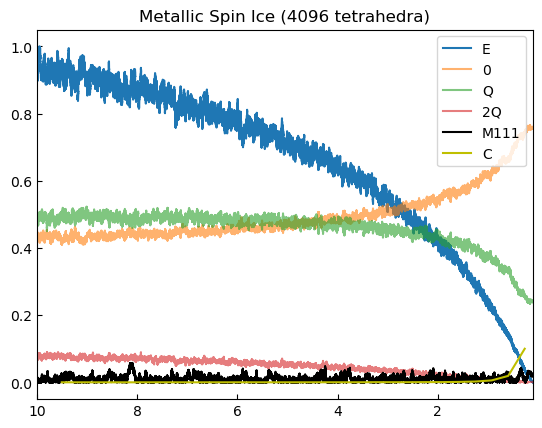

That took  1039.5462181568146  seconds.


In [9]:
N_steps = 1000000

time0 = now()
if state_ini == False: states = (2.0*(np.random.randint(0,2,(10, Npx,Npy,Npz,4)) - 0.5)).astype(int8); state_ini = True

# T = 10*np.ones(N_steps); Tplot = range(N_steps); xlim(0, N_steps)
T = np.linspace(10, 0.1, N_steps); Tplot = T; xlim(T[0], T[-1])
hfields = 0.022* (3**-0.5)*np.ones((N_steps,3))
# hfields = 0.022* np.linspace([0,0,0], [1,1,1], N_steps)
J = 1/4
                                                         # #
states, energy, time = spin_ice_kmc(initial_state=states[-1,:,:,:,:] , N_steps=N_steps, Temp=T,
                                    Nx=Npx, Ny=Npy, Nz=Npz, flip_mode="one-rate", use_gpu=True, verbose = False,
                                    D = 0, J1 = -3, J2 = -3*J, J3a = J, J3b = 0, # D = 0.0, J1 = -3, J2 = -3*J, J3a = J,J3b = 0, # convert to Moesener's Ising language
                                    R = 0, hfields = hfields, eta_mode = "open")
energy = energy[1:] - min(energy[1:])
magnetization = calc_magnetization(states)[1:] / (Npx*Npy*Npz*sum((-1*u0+u1+u2+u3).reshape(-1)))
dN = int(round(N_steps/30)); hdN = int(round(dN/2))
T_hc = np.array([T[n] for n in range(hdN, N_steps, dN)]); Tplot_hc = np.array([Tplot[n] for n in range(hdN, N_steps, dN)])
E_sd = np.array([std(energy[n - hdN : n + hdN : 300]) for n in range(hdN, N_steps, dN)])
heat_capacity = (E_sd**2)/(T_hc**2)
plot(Tplot, energy / max(energy))
plot(Tplot, [[1,2,2]*calc_monopole_population(states[d, :,:,:,:], Npx, Npy, Npz)[2:5]/(2*Npx*Npy*Npz) for d in range(N_steps)], alpha=0.6)
plot(Tplot, abs(magnetization), c='k')
plot(Tplot_hc[1:], 0.1*heat_capacity[1:]/max(heat_capacity[1:]), c='y')
legend(["E", "0", "Q", "2Q", "M111", "C"])
title("Metallic Spin Ice ("+str(2*Npx*Npy*Npz)+" tetrahedra)"); show()
print("That took ", now()-time0, " seconds.")

In [11]:
pstate = states[-1, :,:,:,:]; pstate.shape # last ising state, for test and development

(32, 32, 2, 4)

<h4>Iridium Electrons</h4>

We would like to use the Pr Ising state as given, and convolve the Ir theory to produce inhomogeneous STM.

In [16]:
class TermElement:
    def __init__(self, bond, m):
        self.bond = bond
        self.m = m

def KondoTerm(pspins, Jk):
    spinfieldterms = []
    for n in range(Ni): # over b-sites
        m = np.zeros((2,2), dtype=complex64)
        for b in np.where(nearest_neighbors[1, 0, n, :] == 1)[0]: # b-site:a-site -> 1:0; sum over neighboring pr
            prspin = pspins[b, :]
            m += Jk*(prspin[0]*sigmax + prspin[1]*sigmay + prspin[2]*sigmaz)
        spinfieldterms.append( TermElement(bond = [b, b], m = m) ) # 'bond' is b:b since the hamiltonian only has b positions (onsite)
    return spinfieldterms

def RepulsionTerm(ispins, U):
    repulsionterms = []
    for n in range(Ni):
        irspin = ispins[n, :]
        m = np.array([[0, 0.0],
                      [0.0, 0]], dtype=complex64)
        m -= (4/3)*U*( (irspin[0]*sigmax + irspin[1]*sigmay + irspin[2]*sigmaz) )
        m += (2/3)*U*identity(2)*( np.dot(irspin, irspin) )
        repulsionterms.append( TermElement(bond = [n, n], m = m) )
    return repulsionterms

def HoppingTerm(t, lam):
    hoppings = []
    for n in range(Ni):
        for b in np.where(nearest_neighbors[1, 1, n, :] == 1)[0]: # b-site:b-site -> 1:1
            m = np.array([[t, 0 ],
                          [0,  t]], dtype=complex64)
            v = nu_vectors[n, b, :]
            m -= im*lam*(v[0]*sigmax + v[1]*sigmay + v[2]*sigmaz)
            hoppings.append( TermElement(bond = [n, b], m = m) )
    return hoppings

def construct(TermMap):
    h = np.zeros((2*Ni, 2*Ni), dtype=complex64)
    for term in TermMap:
        m = term.m
        b = term.bond
        for i in range(2):
            for j in range(2):
                h[b[0] + i*Ni, b[1] + j*Ni] += m[i, j]
    return h

def build_h(t, lam, pspins, ispins, U, Jk):
    h = np.zeros((2*Ni, 2*Ni), dtype = complex64)
    if t!=0 or lam!=0:
              h += construct( HoppingTerm(  t,      lam ) )
    if U!=0:  h += construct( RepulsionTerm(ispins, U   ) )
    if Jk!=0: h += construct( KondoTerm(    pspins, Jk  ) )
    return h

# try full interaction model, exact diag 2**N

In [17]:
from scipy.optimize import differential_evolution
# def toflat(vect):
    
def tovect(flat):
    return np.array([ flat[0::3], flat[1::3], flat[2::3] ]).transpose(1,0)
def toeasy(ising):
    easy_vect = np.zeros((Ni,3))
    for mu in range(4):
        easy_vect[mu::4] += np.outer(ising[mu::4], local_axis[mu])
    return easy_vect
def plot_state(spins, tune = 0.2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sites = tune*realspace[1,:,:,:,:,:].reshape((Ni,3))
    ax.scatter(sites[:,0], sites[:,1], sites[:,2], s = 2, color='k')
    ax.quiver(sites[:,0], sites[:,1], sites[:,2], spins[:,0], spins[:,1], spins[:,2], length=0.05, normalize=True, pivot='middle', linewidth=0.6)
    ax.set_axis_off()
    plt.show()

rationale for this model:
...
finite Ir system as tiling of spin order assumption, depart from approx with bigger Ir
are the scales of this model correct? Pr then Ir, big S approx for Pr pseudospin

check: t, lam, U, Jk, Rkky, J's

check: Pr magnetism, Ir magnetism

Now:
<ul>
    <li><s>convolve over Pr periodically</s></li>
    <li>fix thermal broading at edges</li>
</ul>

In [18]:
# initialize tight-binding model, once
t = 1; lam = -0.2
global h_t; h_t = build_h(t, lam, 0, 0, 0, 0)

N_samples = 1 # number of Ir optimization trials
N_energies = 101 # voltage steps, match exp stm

gmap = np.zeros((N_samples, N_energies, Npx, Npy))

# convolve over ising state
for i in range(0, Npx):
    for j in range(0, Npy):
        print("Pr Coord:", i, ", ", j)
        # cut-out set of pr spins the same size as the ir system
        pspins  = np.ones((Ni,3))
        for x in arange(0, Nix):
            if x + i >= Npx: # x-axis periodic over Pr spins
                x -= Npx
            for y in arange(0, Niy):
                if y + j >= Npy: # y-axis periodic over Pr spins
                    y -= Npy
                for z in arange(0, Niz):
                    for mu in arange(0, Nmu):
                        pspins[x+y*Nix+z*Nix*Niy+mu*Nix*Niy*Niz,:] = pstate[i+x,j+y,z,mu] * local_axis[mu]
        
        Jk = 0.15
        global h_tk; h_tk = build_h(0, 0, pspins, 0, 0, Jk) + h_t

        # optimize ir spins

        def build_hu(ispins, U):
            global h_tk

            if U!=0:  h = h_tk + construct( RepulsionTerm(toeasy(ispins), U) )
            return sum(np.sort(eigvals(h).real)[:4])
        for s in range(N_samples):
#             print("Sample", s)
            spins_opt = differential_evolution(build_hu, 
                                               args=[0.2], popsize = 10*Ni, # rule of thumb is 10*N
                                               strategy='best2exp',
                                               bounds = [[-1, 1] for _ in range(Ni)], 
                                               workers=-1, maxiter=1000, atol = 0, tol =1e-3,
                                               disp=False).x
            # much of the compute cost is bound up with the optimization algorithm,
            # consider Monte Carlo method here? or some other cheap method.
            # I will work on tuning the functional code for now.
#             print(spins_opt)

#             plot_state(toeasy(spins_opt))

            hamiltonian = build_h(t = 1, lam = -0.2, 
                          pspins = pspins, #toeasy(pstate[0:2,0:2,0:2,:].reshape(-1)), 
                          ispins = toeasy(spins_opt), U = 0.2, Jk = 0.15)
#             print(hamiltonian.shape)

            # Calculating the Density of States
            spectra = zeros((N_energies,2*Ni))
            energyrange = arange(-0.4,0.402,0.008)


            n = zeros((N_energies,   2*Ni))
            n_w = zeros((N_energies, 2*Ni, 2*Ni))

            for c, w in enumerate(energyrange):
                n_w[c,:,:] = -2*imag(numpy.linalg.inv(w*identity(2*Ni)-hamiltonian[:,:]+1j*0.00001*identity(2*Ni)))

            for r in arange(0,2*Ni):
                n[:,r] = n_w[:,r,r]
            spectra[:,:] = n
            gmap[s,:,i,j] = sum(spectra[:,:], 1)
#             gmap[s,:,i,j] += max(gmap[s,:,i,j])*abs(energyrange) # approximate background
#             plot(energyrange, gmap[s,:,i,j] )
            show()

Pr Coord: 0 ,  0


/home/kyle/anaconda3/envs/alpha/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:533: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


Pr Coord: 0 ,  1
Pr Coord: 0 ,  2
Pr Coord: 0 ,  3
Pr Coord: 0 ,  4
Pr Coord: 0 ,  5
Pr Coord: 0 ,  6
Pr Coord: 0 ,  7
Pr Coord: 0 ,  8
Pr Coord: 0 ,  9
Pr Coord: 0 ,  10
Pr Coord: 0 ,  11
Pr Coord: 0 ,  12
Pr Coord: 0 ,  13
Pr Coord: 0 ,  14
Pr Coord: 0 ,  15
Pr Coord: 0 ,  16
Pr Coord: 0 ,  17
Pr Coord: 0 ,  18
Pr Coord: 0 ,  19
Pr Coord: 0 ,  20
Pr Coord: 0 ,  21
Pr Coord: 0 ,  22
Pr Coord: 0 ,  23
Pr Coord: 0 ,  24
Pr Coord: 0 ,  25
Pr Coord: 0 ,  26
Pr Coord: 0 ,  27
Pr Coord: 0 ,  28
Pr Coord: 0 ,  29
Pr Coord: 0 ,  30
Pr Coord: 0 ,  31
Pr Coord: 1 ,  0
Pr Coord: 1 ,  1
Pr Coord: 1 ,  2
Pr Coord: 1 ,  3
Pr Coord: 1 ,  4
Pr Coord: 1 ,  5
Pr Coord: 1 ,  6
Pr Coord: 1 ,  7
Pr Coord: 1 ,  8
Pr Coord: 1 ,  9
Pr Coord: 1 ,  10
Pr Coord: 1 ,  11
Pr Coord: 1 ,  12
Pr Coord: 1 ,  13
Pr Coord: 1 ,  14
Pr Coord: 1 ,  15
Pr Coord: 1 ,  16
Pr Coord: 1 ,  17
Pr Coord: 1 ,  18
Pr Coord: 1 ,  19
Pr Coord: 1 ,  20
Pr Coord: 1 ,  21
Pr Coord: 1 ,  22
Pr Coord: 1 ,  23
Pr Coord: 1 ,  24
Pr Coord: 1

Pr Coord: 14 ,  9
Pr Coord: 14 ,  10
Pr Coord: 14 ,  11
Pr Coord: 14 ,  12
Pr Coord: 14 ,  13
Pr Coord: 14 ,  14
Pr Coord: 14 ,  15
Pr Coord: 14 ,  16
Pr Coord: 14 ,  17
Pr Coord: 14 ,  18
Pr Coord: 14 ,  19
Pr Coord: 14 ,  20
Pr Coord: 14 ,  21
Pr Coord: 14 ,  22
Pr Coord: 14 ,  23
Pr Coord: 14 ,  24
Pr Coord: 14 ,  25
Pr Coord: 14 ,  26
Pr Coord: 14 ,  27
Pr Coord: 14 ,  28
Pr Coord: 14 ,  29
Pr Coord: 14 ,  30
Pr Coord: 14 ,  31
Pr Coord: 15 ,  0
Pr Coord: 15 ,  1
Pr Coord: 15 ,  2
Pr Coord: 15 ,  3
Pr Coord: 15 ,  4
Pr Coord: 15 ,  5
Pr Coord: 15 ,  6
Pr Coord: 15 ,  7
Pr Coord: 15 ,  8
Pr Coord: 15 ,  9
Pr Coord: 15 ,  10
Pr Coord: 15 ,  11
Pr Coord: 15 ,  12
Pr Coord: 15 ,  13
Pr Coord: 15 ,  14
Pr Coord: 15 ,  15
Pr Coord: 15 ,  16
Pr Coord: 15 ,  17
Pr Coord: 15 ,  18
Pr Coord: 15 ,  19
Pr Coord: 15 ,  20
Pr Coord: 15 ,  21
Pr Coord: 15 ,  22
Pr Coord: 15 ,  23
Pr Coord: 15 ,  24
Pr Coord: 15 ,  25
Pr Coord: 15 ,  26
Pr Coord: 15 ,  27
Pr Coord: 15 ,  28
Pr Coord: 15 ,  29
Pr C

Pr Coord: 28 ,  0
Pr Coord: 28 ,  1
Pr Coord: 28 ,  2
Pr Coord: 28 ,  3
Pr Coord: 28 ,  4
Pr Coord: 28 ,  5
Pr Coord: 28 ,  6
Pr Coord: 28 ,  7
Pr Coord: 28 ,  8
Pr Coord: 28 ,  9
Pr Coord: 28 ,  10
Pr Coord: 28 ,  11
Pr Coord: 28 ,  12
Pr Coord: 28 ,  13
Pr Coord: 28 ,  14
Pr Coord: 28 ,  15
Pr Coord: 28 ,  16
Pr Coord: 28 ,  17
Pr Coord: 28 ,  18
Pr Coord: 28 ,  19
Pr Coord: 28 ,  20
Pr Coord: 28 ,  21
Pr Coord: 28 ,  22
Pr Coord: 28 ,  23
Pr Coord: 28 ,  24
Pr Coord: 28 ,  25
Pr Coord: 28 ,  26
Pr Coord: 28 ,  27
Pr Coord: 28 ,  28
Pr Coord: 28 ,  29
Pr Coord: 28 ,  30
Pr Coord: 28 ,  31
Pr Coord: 29 ,  0
Pr Coord: 29 ,  1
Pr Coord: 29 ,  2
Pr Coord: 29 ,  3
Pr Coord: 29 ,  4
Pr Coord: 29 ,  5
Pr Coord: 29 ,  6
Pr Coord: 29 ,  7
Pr Coord: 29 ,  8
Pr Coord: 29 ,  9
Pr Coord: 29 ,  10
Pr Coord: 29 ,  11
Pr Coord: 29 ,  12
Pr Coord: 29 ,  13
Pr Coord: 29 ,  14
Pr Coord: 29 ,  15
Pr Coord: 29 ,  16
Pr Coord: 29 ,  17
Pr Coord: 29 ,  18
Pr Coord: 29 ,  19
Pr Coord: 29 ,  20
Pr Coord: 29 

In [ ]:
eRange = arange(-100, 101, 2)
for e in range(30, 51, 2):
    print(eRange[e],"meV")
    matshow(gmap_sim_unit[e,:,:])
    show()

<h4>Matching Simulation to Experment</h4>

<ul>
    <li>Get PIO Experimental STM
    <li>Train K-Means on it
    <li>Train NN on the randomized Sim $->$ Exp Mapping
    <li>Sort Sim STM with trained K-Means
    <li>How does it look?</ul>

In [23]:
# quick hard-code
gmap_sim = deepcopy(gmap[0,:,:,:])

In [26]:
# Initialize notebook and dependencies
from sklearn.cluster import KMeans

# Load the STM data
mat_data = scipy.io.loadmat('/home/kyle/code/stm-ml_pio/data/Pr2Ir2O7-Data0067.mat') # from pathlib import Path; path = Path("../file.txt"); print(path.parent.absolute())
gmap_exp = mat_data['data0067']
Ne, Nx_exp, Ny_exp = gmap_exp.shape

In [27]:
# Let's add some thermal broadening with a Gaussian Convolution
# Width-at-half-maximum is approximately k_B*T, k_B = 8.61733*10**-2 # meV/K -> meaning 100meV ~ 1160 K
# Going to work in units of Kelvin and convert to meV for figures

def Gaussian(a, b, c, x): # amp, shift, half, dom
    y = zeros(x.shape[0])
    for r in arange(0,x.shape[0]):
        y[r] = a*(e**-(((x[r]-b)**2)/(2*(c**2))))
    return y

def Lorentzian(a, r0, w, x): # amp, shift, half, dom
    y = zeros(x.shape[0])
    for r in arange(0,x.shape[0]):
        W = (r0-x[r])/(w/2)
        y[r] = a/(1+W**2)
    return y

def ThermalBroadening(A, x, w, typ="Gauss"): # func, dom (in meV), half-width (in meV)
    
    L = A.shape[0] # length of original
    y = np.zeros(L) # initialize convolved function
    
    for r in arange(0, L): # build y by scanning left to right
        if typ == "Gauss": # prefactor accounts for diminishing area at boundaries (-x[L] assumed to compensate for right)
#             print((2/(1+scipy.special.erf((r)/(sqrt(2)*w)))))

            B =   (2/(1+scipy.special.erf((r)/(sqrt(2)*w)))) * Gaussian(1, x[r], w, x) # unit amplitude, shift dist center, half-width, dom
        if typ == "Lorentz":
            B = Lorentzian(1, x[r], w, x)
            
        for p in arange(0, L): # sample convolution
            y[r] += A[p]*B[p]
    return y

# issue with convolution at boundary, zero multiplication brings the function down
# have considered periodic or constant boundaries
# a simpler solution is just to do no convolution (or attenuated) at the boundary
def ThermalBroadening_old(A,x,T,typ="Gauss"):
    y = zeros(A.shape[0])
    for r in arange(0,A.shape[0]):
        if typ == "Gauss":
            B = Gaussian(1,x[r],k_B*T,x)
        if typ == "Lorentz":
            B = Lorentzian(1,x[r],k_B*T,x)
        for p in arange(0,A.shape[0]):
            y[r] += A[p]*B[p]
    return y

What is the appropriate way to scale the peak? The magnitude and location of the peak are important,
but it should be within the realm of the experimental peaks.

In [ ]:
eRange = arange(-100, 101, 2)
for i in range(Npx):
    for j in range(Npy):
        plot(eRange,gmap_sim[:,i,j])
        plot(eRange,1+ThermalBroadening(gmap_sim[:,i,j], eRange, 10))
        show()

In [29]:
# Normalize the dataset for interaction with ML algorithm
def normalize(gmap, mode = 'none'):
    gmap_ = deepcopy(gmap)
    for i in range(gmap.shape[1]):
        for j in range(gmap.shape[2]):
            if mode == 'thermal':
                gmap_[:,i,j] = ThermalBroadening(gmap[:,i,j], arange(-100,101,2), 20)
            gmap_[:,i,j] -= mean(gmap_[:,i,j])
            gmap_[:,i,j] /= norm(gmap_[:,i,j])
            
            gmap_ = where(np.isnan(gmap_), 0, gmap_)
    return gmap_
gmap_exp_unit = normalize(gmap_exp)
gmap_sim_unit = normalize(gmap_sim, mode='thermal')

In [ ]:
plot(0.2*gmap_sim_unit[:,0,0])
plot((0.2*gmap_sim_unit[:,0,0]+mean_spectra))
plot(mean_spectra)

In [ ]:
# Compute K-means algorithm for K = 2, main output is the clustermap
Nc = 7

clf_km = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters = Nc, n_init=3, 
    random_state=None, tol=10**-6, verbose=False)

clustermap_exp = clf_km.fit_predict(gmap_exp_unit[:,:,:].reshape((Ne,Nx_exp*Ny_exp)).transpose(1,0)).reshape((Nx_exp,Ny_exp))

In [ ]:
# Collect dataset for training NN
Nd = 1000
X = np.zeros((Nd, Ne), dtype=float32)
Y = np.zeros((Nd, Ne), dtype=float32)
for d in range(Nd):
    i, j = randint(0,Npx), randint(0,Npy)
    m, n = randint(0,Nx_exp), randint(0,Ny_exp)
    X[d,:] = gmap_sim_unit[ :, i, j]
    Y[d,:] = gmap_exp_unit[:, m, n]
    if d < 10:
        plot(X[d,:])
        plot(Y[d,:])
        show()

store spins

In [228]:
mean_spectra = mean(gmap_exp_unit.reshape(101, 64*64), axis=1)

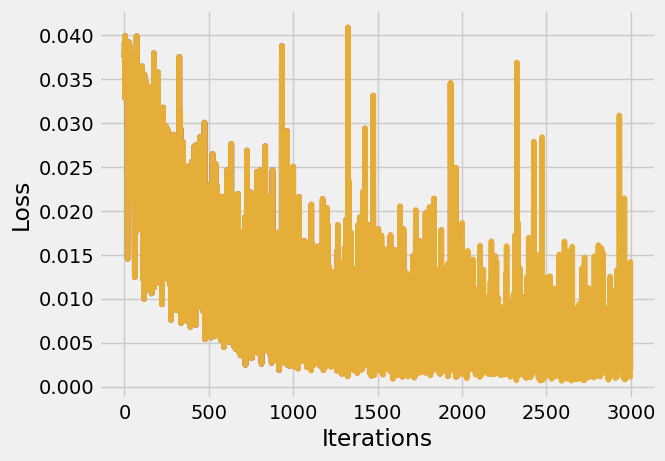

In [277]:
# Build and train model
import torch
from torchvision import transforms
tensor_transform = transforms.ToTensor()

class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(101, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 101),
#             torch.nn.Conv1d(1, 1, 7, stride=1, padding=3, padding_mode='circular')
#             torch.nn.ReLU()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded+x

# Model Initialization
model = NN()#.to(device)
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-4,
                             weight_decay = 1e-8)

epochs = 3
outputs = []
losses = []
for epoch in range(epochs):
    for d in range(Nd):
        x = tensor_transform(X[d,:].reshape(-1, 101))
        y = tensor_transform(Y[d,:].reshape(-1, 101))
        mapped = model(x)
        
        loss = loss_function(mapped, y) # .cuda() .cpu()

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(torch.Tensor.detach(loss).numpy())
        outputs.append((epochs, y, mapped))
 
    # Plot loss
#     plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(losses)

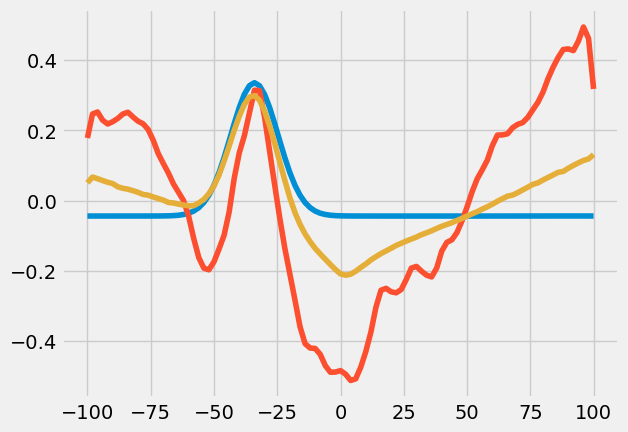

In [278]:
plot(eRange,gmap_sim_unit[:,0,0])
plot(eRange,ThermalBroadening(model(tensor_transform(gmap_sim_unit[:,0,0].reshape(-1,Ne).astype(float32))).detach().numpy()[0,0,:],eRange,5))
plot(eRange,gmap_sim_unit[:,0,0]+mean_spectra)

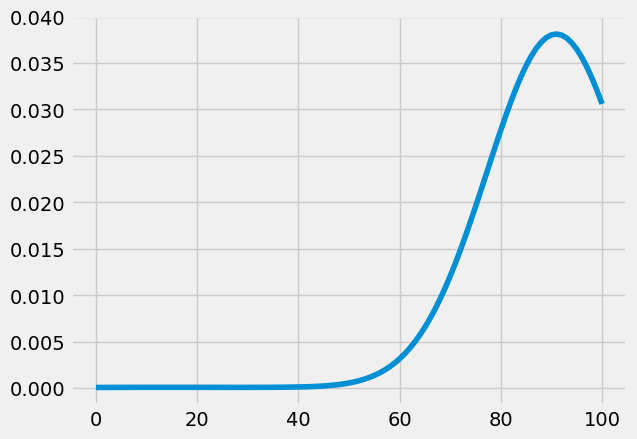

In [400]:
plot(gmap_sim_unit[:,0,0])

In [242]:
# Transform the simulated stm with the NN
gmap_sim_tran = np.zeros(gmap_sim_unit.shape)
for i in range(Npx):
    for j in range(Npy):
        gmap_sim_tran[:,i,j] = 0.2*gmap_sim_unit[:,i,j] + mean_spectra
#         gmap_sim_tran[:,i,j] = model(tensor_transform(gmap_sim_unit[:,i,j].reshape(-1, Ne).astype(float32))).detach().numpy()
# #         gmap_sim_tran[:,i,j] = ThermalBroadening(gmap_sim_tran[:,i,j],arange(-100,101,2),1e6)
gmap_sim_tran = normalize(gmap_sim_tran)

In [ ]:
# classify transformed simulated stm with K-Means
clustermap_sim = clf_km.predict(gmap_sim_tran[:,:,:].reshape((Ne,Npx*Npy)).transpose(1,0)).reshape((Npx,Npy))

# How does it look?
matshow(clustermap_exp); matshow(clustermap_sim)

plot sim, unit_sim, tran_sim and is classifying like exp
where is the bump coming from?

In [259]:
clustermap_exp[0,0]

1

In [250]:

for i in range(5):
    for j in range(5):
        if clustermap_exp[i,j] == 2 and clustermap_sim[i,j] == 2:
            plot(gmap_exp_unit[:,i,j],c='b')
            plot(gmap_sim_tran[:,i,j],c='r')
        show()

do not add, just refine
tune energy scales, model parameters
fix, optimize, review Chen and Jaubert
We'll reach out to Pegor this week and get his feedback.
Prepare a quick presentation.